In [69]:
import pandas as pd
import geopandas as gpd
import requests
from bs4 import BeautifulSoup
import transCoordinateSystem as tr
from tqdm import tqdm #显示处理进度

In [70]:
def page_analyse(url):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36"}
    building = requests.get(url,headers=headers)
    html1 = building.text
    soup1= BeautifulSoup(html1,"lxml")
    #获取写字楼的名称
    building_name = soup1.find_all(name="h1",attrs = {"class":"fl"})[0].text
    #获取租金
    building_price = soup1.find_all(name = "span",attrs = {"class":"price-num"})[0].text
    #获取物业费
    for i in soup1.find_all(name ="span",attrs={"class":"f-con"}):
        if "平" in i.text:
            property_fee = i.text
    try:
        a = property_fee
    except:
        property_fee = ""
    #获取经纬度并纠偏（转为wgs1984）
    longitude = float(soup1.find_all(name="span",attrs={"id":"longitude"})[0].text)
    latitude =float(soup1.find_all(name="span",attrs={"id":"latitude"})[0].text)
    location = tr.bd09_to_wgs84(latitude,longitude)
    lon_wgs1984 = round(location[1],6)
    lat_wgs1984 = round(location[0],6)

    return {"写字楼名称":building_name,
            "租金":building_price,
            "物业费":property_fee,
            "纬度":lat_wgs1984,
            "经度":lon_wgs1984}
       

In [71]:
data=[]
for i in tqdm(range(1,4)):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36"}
    url ="https://sz.diandianzu.com/listing/r18p"+str(i)+"/"
    a = requests.get(url,headers=headers)
    html = a.text
    soup = BeautifulSoup(html,"lxml")
    for page in soup.find_all(name ="div",attrs={"class":"list-item-link"}):
        building_url = "https://sz.diandianzu.com" + page.find_all(name="a",attrs={"target":"_blank"})[0]["href"]
        data.append(page_analyse(building_url))
   


100%|██████████| 3/3 [00:11<00:00,  3.89s/it]


## 空间数据处理与存储

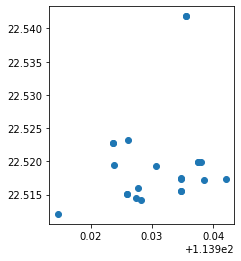

In [81]:
df = pd.DataFrame()
df=df.append(data,ignore_index=True)
gdf = gpd.GeoDataFrame(df,geometry = gpd.points_from_xy(df.经度,df.纬度))
gdf.crs = "EPSG:4326"
gdf.plot()
gdf.to_file(r"D:\科研数据处理\立方数据学社\python城市数据爬取\python城市数据爬取练习\空间数据爬取\写字楼.shp",encoding ="gb18030")
gdf.to_csv(r"D:\科研数据处理\立方数据学社\python城市数据爬取\python城市数据爬取练习\空间数据爬取\写字楼.csv",encoding='utf-8')